# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Experiments-(syntax-tree,-build-process,-specification)" data-toc-modified-id="Experiments-(syntax-tree,-build-process,-specification)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Experiments (syntax tree, build process, specification)</a></div><div class="lev2 toc-item"><a href="#Experiments-collection" data-toc-modified-id="Experiments-collection-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Experiments collection</a></div><div class="lev1 toc-item"><a href="#Results-(processing,-list,-plotting)" data-toc-modified-id="Results-(processing,-list,-plotting)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Results (processing, list, plotting)</a></div><div class="lev1 toc-item"><a href="#Testing-(UX,-DX)" data-toc-modified-id="Testing-(UX,-DX)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Testing (UX, DX)</a></div>

In [1]:
import sys
sys.executable

'/Users/Nikhil/Desktop/ccn-benchmarks/venv/bin/python3.7'

In [2]:
from IPython.display import display, set_matplotlib_formats
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
set_matplotlib_formats('retina')
sns.set(rc={"figure.figsize": (6, 4)})
sns.set_style('ticks')
sns.set_context('notebook', rc={"lines.linewidth": 2.5})

# Experiments (syntax tree, build process, specification)

In [3]:
from collections import namedtuple

Stimulus = namedtuple('Stimulus', ['stim', 'start', 'end', 'mag'], defaults=(1,))
Trial = namedtuple('Trial', ['cs', 'ctx', 'us'])  # Trial(cs=(Stimulus('A', 4, 8, 1),), ctx='K1', us=Stimulus('+', 7, 8, 1) or None)
Sample = namedtuple('Sample', ['prob'])  # Sample(prob={ x: 1, y: 1 })
Sequence = namedtuple('Sequence', ['children', 'repeat', 'name'], defaults=(1, None))  # Sequence(children=(...), repeat=1, name='train' or None)

def trial(*args, ctx='K1', us_mapping={ '+': 1, '-': 0 }, cs_active=(4, 8), us_active=(7, 8)):
    cs = tuple()
    us = None
    assert isinstance(ctx, str)
    if isinstance(args[0], str):
        # Usage: trial('AB+')
        assert len(args) == 1
        for char in args[0]:
            if char in us_mapping:
                us = Stimulus('+', us_active[0], us_active[1], us_mapping[char])
            else:
                cs += (Stimulus(char, cs_active[0], cs_active[1], 1),)
    else:
        for item in args:
            if len(item) == 4:
                # Usage: trial(('A', 4, 8, 0.5), ('B', 4, 8, 0.5), ('+', 7, 8, 0.8))
                stim, start, end, mag = item
                assert isinstance(stim, str)
                assert isinstance(start, int)
                assert isinstance(end, int)
                assert isinstance(mag, (int, float))
                us = Stimulus(stim, start, end, mag)
            else:
                # Usage: trial(('A', 4, 8), ('B', 4, 8), ('+', 7, 8))
                assert len(item) == 3
                stim, start, end = item
                if stim in us_mapping:
                    us = Stimulus('+', start, end, us_mapping[stim])
                else:
                    cs += (Stimulus(*item),)
    return Trial(cs, ctx=ctx, us=us)
        
def seq(*children, repeat=1, name=None):
    return Sequence(children, repeat=repeat, name=name)

def sample(prob):
    return Sample(prob)

print(trial('AB+'))
print(trial(('A', 4, 8), ('B', 4, 8), ('+', 7, 8)))
print(seq(
    sample({
        trial('A+'): 8,
        trial('A-'): 2,
    }),
    repeat=1,
))

Trial(cs=(Stimulus(stim='A', start=4, end=8, mag=1), Stimulus(stim='B', start=4, end=8, mag=1)), ctx='K1', us=Stimulus(stim='+', start=7, end=8, mag=1))
Trial(cs=(Stimulus(stim='A', start=4, end=8, mag=1), Stimulus(stim='B', start=4, end=8, mag=1)), ctx='K1', us=Stimulus(stim='+', start=7, end=8, mag=1))
Sequence(children=(Sample(prob={Trial(cs=(Stimulus(stim='A', start=4, end=8, mag=1),), ctx='K1', us=Stimulus(stim='+', start=7, end=8, mag=1)): 8, Trial(cs=(Stimulus(stim='A', start=4, end=8, mag=1),), ctx='K1', us=Stimulus(stim='+', start=7, end=8, mag=0)): 2}),), repeat=1, name=None)


In [4]:
import random
from collections import defaultdict

def build_trial(node):
    cs, ctx, us = node
    length = 0
    
    cs_t = defaultdict(list)
    if cs is not None:
        for stim, start, end, mag in cs:
            length = max(length, end)
            for t in range(start, end):
                cs_t[t].append((stim, mag))
    
    us_t = defaultdict(int)
    if us is not None:
        stim, start, end, mag = us
        length = max(length, end)
        for t in range(start, end):
            us_t[t] = mag
    
    return [(cs_t[t], ctx, us_t[t]) for t in range(length)]

def build_stimuli(node):
    # (cs, ctx, us) = stimuli[trial][timestep]
    # phase = phases[trial]
    stimuli = []
    phases = []
    
    def recurse(node, phase):
        name = type(node).__name__
        if name == 'Trial':
            trial = build_trial(node)
            stimuli.append(trial)
            phases.append(phase)
        if name == 'Sample':
            choices = list(node.prob.keys())
            weights = list(node.prob.values())
            choice = random.choices(choices, weights=weights)[0]
            recurse(choice, phase)
        if name == 'Sequence':
            for _ in range(node.repeat):
                for child in node.children:
                    recurse(child, node.name if node.name is not None else phase)
    
    recurse(node, None)
    return stimuli, phases

In [5]:
display(build_stimuli(trial('AB+')))
display(build_stimuli(sample({ trial('A'): 1, trial('B'): 1 })))
display(build_stimuli(seq(trial('A'), trial('B'), repeat=3)))
display(build_stimuli(seq(sample({ trial('A'): 1, trial('B'): 1 }), repeat=4)))

([[([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1), ('B', 1)], 'K1', 0),
   ([('A', 1), ('B', 1)], 'K1', 0),
   ([('A', 1), ('B', 1)], 'K1', 0),
   ([('A', 1), ('B', 1)], 'K1', 1)]],
 [None])

([[([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0)]],
 [None])

([[([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], '

([[([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0)]],
 [None, None, None, None])

In [73]:
def listdict_to_dictlist(ld):
    dl = defaultdict(list)
    keys = set(k for d in ld for k in d)
    for d in ld:
        for k in keys:
            dl[k].append(d[k] if k in d else None)
    return dl

listdict_to_dictlist([{ 'response': 1 }, { 'response': 2, 'foo': 2 }, { 'response': 3 }])

defaultdict(list, {'response': [1, 2, 3], 'foo': [None, 2, None]})

In [540]:
import fnmatch

class SearchableCollection:
    def __call__(self, *globs, execute=True):
        """Execute the selected functions/constructors using default parameters."""
        fns = [name for name in dir(self) if not name.startswith('_') and callable(getattr(self, name))]
        if len(globs) > 0: fns = [name for name in fns if any(fnmatch.fnmatch(name, g) for g in globs)]
        return [getattr(self, name)() if execute else getattr(self, name) for name in fns]

class ExperimentsCollection(SearchableCollection):
    def __call__(self, *globs, use_defaults=True):
        return super().__call__(*globs, execute=use_defaults)

class ClassicalConditioningExperiment:
    def __init__(self, spec):
        self.spec = spec
        self.stimuli = {}
        self.phases = {}
        for group, node in spec.items():
            self.stimuli[group], self.phases[group] = build_stimuli(node)
            
        
        cs_space = set()
        ctx_space = set()
        for stimuli in self.stimuli.values():
            for trial in stimuli:
                for timestep in trial:
                    cs, ctx, us = timestep
                    cs_space.update(*[stim for stim, mag in cs])
                    ctx_space.add(ctx)
        self.cs_space = tuple(sorted(cs_space))
        self.ctx_space = tuple(sorted(ctx_space))
        
        self.data = {
            group: [[defaultdict(list) for timestep in trial] for trial in stimuli]
            for group, stimuli in self.stimuli.items()
        }
        
        self.name = self.__class__.__name__
        self.meta = {}
        self.results = None
        self.plots = []
        
    def stimulus(self, group, trial, timestep, vector=False):
        stimuli = self.stimuli[group][trial][timestep]
        if not vector: return stimuli
        cs, ctx, us = stimuli
        cs_vec = [next((mag for stim, mag in cs if x == stim), 0) for x in self.cs_space]
        ctx_vec = [1 if x == ctx else 0 for x in self.ctx_space]
        return cs_vec, ctx_vec, us
    
    def phase(self, group, trial):
        return self.phases[group][trial]
    
    def dataframe(self, fn, var='response', phase=False):
        # fn: (args) => { 'col': value, ... }
        # self.stimuli[group][trial]
        # self.data[group][trial][var][subject]
        data = []
        for g, group in self.stimuli.items():
            for i, timesteps in enumerate(group):
                # [timestep][var][subject] -> [var][timestep][subject] -> [timestep][subject]
                x = listdict_to_dictlist(self.data[g][i])[var]
                # [timestep][subject] -> [subject][timestep]
                x = zip(*x)
                for values in x:
                    p = self.phases[g][i]
                    kwargs = {
                        var: values,
                        'timesteps': timesteps,
                        'group': g,
                        'trial': i + 1,
                        'phase': p,
                    }
                    cols = fn(kwargs)
                    if cols is not None:
                        data.append({ 'group': g, 'trial': i + 1, **({ 'phase': p } if phase else {}), **cols })
        return pd.DataFrame(data)
    
    def summarize(self):
        raise NotImplementedError
        
    def plot(self, show='both', figsize=(6, 4), axes=None, xlabel=True, ylabel=True):
        # show: 'empirical' | 'simulation' | 'both'
        for plotfn in self.plots:
            if show == 'empirical':
                dfs = [self.results]
                fig, ax = plt.subplots(figsize=figsize)
                axes = [ax]
                kind = ['empirical']
            elif show == 'simulation':
                dfs = [self.summarize()]
                fig, ax = plt.subplots(figsize=figsize)
                axes = [ax]
                kind = ['simulation']
            else:
                dfs = [self.results, self.summarize()]
                fig, axes = plt.subplots(1, 2, figsize=(figsize[0] * 2, figsize[1]))
                kind = ['empirical', 'simulation']
            
            for i, df in enumerate(dfs):
                xlab = ''
                if xlabel:
                    xlab = self.meta.get('xlabel', None)
                    if kind[i] == 'empirical': xlab = self.meta.get('xdetail', xlab)
                ylab = ''
                if ylabel:
                    ylab = self.meta.get('ylabel', None)
                    if kind[i] == 'empirical': ylab = self.meta.get('ydetail', ylab)
                plotfn(
                    df,
                    axes[i],
                    xlabel=xlab,
                    ylabel=ylab,
                    kind=kind[i]
                )

## Experiments collection

In [556]:
class ClassicalConditioningExperiments(ExperimentsCollection):
    
    # ====================================================================================================
    # 1. Acquisition 
    class Acquisition_ContinuousPartial(ClassicalConditioningExperiment):
        def __init__(self, n=64, partial_prob=0.5):
            super().__init__({
                'continuous': seq(
                    trial('A+'),
                    repeat=n,
                    name='train',
                ),
                'partial': seq(
                    sample({
                        trial('A+'): partial_prob,
                        trial('A-'): 1 - partial_prob,
                    }),
                    repeat=n,
                    name='train',
                ),
            })
            # 1.1, 1.2 - figure 2
            self.meta = dict(
                ylabel='conditioned response',
                ydetail='mean time to error [s]',
                citation='Wagner et al. (1967)',
            )
            self.results = pd.melt(pd.DataFrame(
                columns=['group', 'session', 'A'],
                data=[
                    ['continuous', 0, 0],
                    ['continuous', 1, 14],
                    ['continuous', 2, 17],
                    ['continuous', 3, 18],
                    ['continuous', 4, 17.5],
                    ['partial', 0, 0],
                    ['partial', 1, 10],
                    ['partial', 2, 16],
                    ['partial', 3, 13],
                    ['partial', 4, 15],
                ]
            ), id_vars=['group', 'session'])
            self.plots = [
                lambda df, ax, **kwargs: plot_lines(df, ax=ax, x='session', xlabel=kwargs['xlabel'], ylabel=kwargs['ylabel'])
            ]
            
        def summarize(self):
            return trials_to_sessions(pd.melt(
                self.dataframe(lambda x: {
                    'A': conditioned_response(x['timesteps'], x['response'], ['A']),
                }),
                id_vars=['group', 'trial']
            ).groupby(['group', 'trial', 'variable'], sort=False).mean().reset_index(), 16, keep_first=True)
    
    # ====================================================================================================
    # 2. Extinction
    class Extinction_ContinuousPartial(ClassicalConditioningExperiment):
        def __init__(self, n=10, partial_prob=0.5):
            super().__init__({
                'continuous': seq(
                    seq(
                        trial('A+'),
                        repeat=n,
                        name='train',
                    ),
                    seq(
                        trial('A-'),
                        repeat=n,
                        name='extinction',
                    )
                ),
                'partial': seq(
                    seq(
                        sample({
                            trial('A+'): partial_prob,
                            trial('A-'): 1 - partial_prob,
                        }),
                        repeat=n,
                        name='train',
                    ),
                    seq(
                        trial('A-'),
                        repeat=n,
                        name='extinction',
                    )
                ),
            })
            # 2.1, 2.2 - figure 6
#             self.meta = dict(
#                 ylabel='conditioned response',
#                 ydetail='mean time to error [s]',
#                 citation='Wagner et al. (1967)',
#             )
#             self.results = pd.melt(pd.DataFrame(
#                 columns=['group', 'session', 'A'],
#                 data=[
#                     ['continuous', 0, 0],
#                     ['continuous', 1, 14],
#                     ['continuous', 2, 17],
#                     ['continuous', 3, 18],
#                     ['continuous', 4, 17.5],
#                     ['partial', 0, 0],
#                     ['partial', 1, 10],
#                     ['partial', 2, 16],
#                     ['partial', 3, 13],
#                     ['partial', 4, 15],
#                 ]
#             ), id_vars=['group', 'session'])
#             self.plots = [
#                 lambda df, ax, **kwargs: plot_lines(df, ax=ax, x='session', xlabel=kwargs['xlabel'], ylabel=kwargs['ylabel'])
#             ]
            
#         def summarize(self):
#             return trials_to_sessions(pd.melt(
#                 self.dataframe(lambda x: {
#                     'A': conditioned_response(x['trial'], x['response'], ['A']),
#                 }),
#                 id_vars=['group', 'trial']
#             ).groupby(['group', 'trial', 'variable']).mean().reset_index(), 16, keep_first=True)
    
    # ====================================================================================================
    # 3. Generalization
    class Generalization_NovelVsInhibitor(ClassicalConditioningExperiment):
        def __init__(self, n=10):
            training = [
                seq(
                    trial('A+'),
                    trial('B+'),
                    repeat=n,
                    name='train 1',
                ),
                seq(
                    trial('A+'),
                    trial('B+'),
                    trial('BX-'),
                    repeat=n,
                    name='train 2',
                ),
            ]
            super().__init__({
                'control': seq(
                    *training,
                    seq(
                        trial('A'),
                        repeat=n,
                        name='test',
                    ),
                ),
                'external inhibition': seq(
                    *training,
                    seq(
                        trial('AC'),
                        repeat=n,
                        name='test',
                    ),
                ),
                'conditioned inhibition': seq(
                    *training,
                    seq(
                        trial('AX'),
                        repeat=n,
                        name='test',
                    ),
                ),
            })
            # 3.2 - figure 8
            self.meta = dict(
                ylabel='conditioned response',
                ydetail='ratings',
                citation='Kutlu & Schmajuk (2012)',
            )
            self.results = pd.DataFrame(
                columns=['group', 'variable', 'value'],
                data=[
                    ['control', 'A', 9],
                    ['external inhibition', 'AC', 5.5],
                    ['conditioned inhibition', 'AX', 2],
                ]
            )
            self.plots = [
                lambda df, ax, **kwargs: plot_bars(df, ax=ax, x='group', split=None, xlabel=kwargs['xlabel'], ylabel=kwargs['ylabel'])
            ]
            
        def summarize(self): 
            df = pd.melt(
                self.dataframe(lambda x: {
                    **({ 'A': conditioned_response(x['timesteps'], x['response'], ['A']) } if x['group'] == 'control' else {}),
                    **({ 'AC': conditioned_response(x['timesteps'], x['response'], ['A', 'C']) } if x['group'] == 'external inhibition' else {}),
                    **({ 'AX': conditioned_response(x['timesteps'], x['response'], ['A', 'X']) } if x['group'] == 'conditioned inhibition' else {}),
                } if x['phase'] == 'test' else None),
                id_vars=['group', 'trial']
            ).drop(columns=['trial'])
            return df.groupby(['group', 'variable'], sort=False).mean().dropna().reset_index()
            
    class Generalization_AddVsRemove(ClassicalConditioningExperiment):
        def __init__(self, n=10, partial_prob=0.5):
            test_phase = seq(
                trial('A'),
                trial('AB'),
                trial('ABC'),
                name='test',
            )
            super().__init__({
                'A': seq(
                    seq(trial('A+'), repeat=n, name='train'),
                    test_phase,
                ),
                'AB': seq(
                    seq(trial('AB+'), repeat=n, name='train'),
                    test_phase,
                ),
                'ABC': seq(
                    seq(trial('ABC+'), repeat=n, name='train'),
                    test_phase,
                ),
            })
    
    # ====================================================================================================
    # 4. Discrimination
    class Discrimination_ConditionedVsBaseline(ClassicalConditioningExperiment):
        def __init__(self, n=10):
            super().__init__({
                'main': seq(
                    trial('A+'),
                    trial('B-'),
                    repeat=n,
                    name='train',
                ),
            })
            
    class Discrimination_PositivePatterning(ClassicalConditioningExperiment):
        def __init__(self, n=10):
            super().__init__({
                'main': seq(
                    trial('AB+'),
                    trial('A-'),
                    trial('B-'),
                    repeat=n,
                    name='train',
                ),
            })
    
    class Discrimination_NegativePatterning(ClassicalConditioningExperiment):
        def __init__(self, n=10):
            super().__init__({
                'main': seq(
                    trial('AB-'),
                    trial('A+'),
                    trial('B+'),
                    repeat=n,
                    name='train',
                ),
            })
    
    # ====================================================================================================
    # 5. Inhibition
    
    # ====================================================================================================
    # 6. Combination
    
    # ====================================================================================================
    # 7. Competition
    
    # ====================================================================================================
    # 8. PreExposure
    
    # ====================================================================================================
    # 9. Transfer
    
    # ====================================================================================================
    # 10. Recovery
    
    # ====================================================================================================
    # 11. HigherOrder
    
    # ====================================================================================================
    # 12. Temporal
    

experiments = ClassicalConditioningExperiments()

In [9]:
# experiments('Acq*')
experiments.Acquisition_ContinuousPartial()

In [39]:
exp = experiments.Acquisition_ContinuousPartial()
print(exp.cs_space)
print(exp.ctx_space)
print(exp.stimulus('continuous', 0, 7))
print(exp.stimulus('continuous', 0, 7, vector=True))

('A',)
('K1',)
([('A', 1)], 'K1', 1)
([1], [1], 1)


In [377]:
def print_spec(spec):
    display(spec)
    
# continuous:
#     train(ctx='K1') 10x {
#         p=2:
#             10x { AB+ }
#         p=1:
#             name 10x {
            
#             }
#     }
# partial:
#     train 10x {
#         5x { AB+ }
#         5x { A->B+ }
#     }

# partial:
#     train 10x [
#

def print_trial(trial):
    display(trial)

# A: _ _ _ _ 1 1 1 1
# B: _ _ _ _ 1 1 1 1
# +: _ _ _ _ _ _ _ 1

# CR:0 0 1 0 0 1 1 1
    
print_spec(exp.spec)
print_trial(exp.stimuli['continuous'][0])

{'continuous': Sequence(children=(Trial(cs=(Stimulus(stim='A', start=4, end=8, mag=1),), ctx='K1', us=Stimulus(stim='+', start=7, end=8, mag=1)),), repeat=10, name='train'),
 'partial': Sequence(children=(Sample(prob={Trial(cs=(Stimulus(stim='A', start=4, end=8, mag=1),), ctx='K1', us=Stimulus(stim='+', start=7, end=8, mag=1)): 0.5, Trial(cs=(Stimulus(stim='A', start=4, end=8, mag=1),), ctx='K1', us=Stimulus(stim='+', start=7, end=8, mag=0)): 0.5}),), repeat=10, name='train')}

[([], 'K1', 0),
 ([], 'K1', 0),
 ([], 'K1', 0),
 ([], 'K1', 0),
 ([('A', 1)], 'K1', 0),
 ([('A', 1)], 'K1', 0),
 ([('A', 1)], 'K1', 0),
 ([('A', 1)], 'K1', 1)]

# Results (processing, list, plotting)

In [372]:
def count_responses(stimuli, responses, during_cs=None, during_ctx=None, during_us=None):
    # (cs, ctx, us) = stimuli[timestep]
    # response = responses[timestep]
    def include(stimulus):
        cs, ctx, us = stimulus
        result = True
        if during_cs is not None:
            result &= len(cs) == len(during_cs) and all(stim in during_cs for stim, mag in cs)
        if during_ctx is not None:
            result &= ctx == during_ctx
        if during_us is not None:
            result &= us > 0 if during_us else us == 0
        return result

    return sum(responses[i] for i, stimulus in enumerate(stimuli) if include(stimulus))

def conditioned_response(stimuli, responses, during_cs, during_us=False):
    num = count_responses(stimuli, responses, during_cs=during_cs, during_us=during_us)
    denom = count_responses(stimuli, [1] * len(responses), during_cs=during_cs, during_us=during_us)
    if denom == 0: return 0
    return float(num) / denom

def suppression(stimuli, responses, during_cs, during_us=False):
    cs = count_responses(stimuli, responses, during_cs=during_cs, during_us=during_us)
    ctx = count_responses(stimuli, responses, during_cs=[], during_us=during_us)
    num = ctx - cs
    denom = ctx
    if denom == 0: return 0
#     num = cs + 1
#     denom = cs + ctx + 2
    return float(num) / denom

def suppression_ratio(stimuli, responses, during_cs, during_us=False):
    cs = count_responses(stimuli, responses, during_cs=during_cs, during_us=during_us)
    ctx = count_responses(stimuli, responses, during_cs=[], during_us=during_us)
    num = cs
    denom = cs + ctx
    if denom == 0: return 0
#     num = cs + 1
#     denom = cs + ctx + 2
    return float(num) / denom

stimuli, phases = build_stimuli(trial('AB+'))
stimuli = stimuli[0]
responses = [0, 0, 1, 0, 0, 1, 1, 1]
display(stimuli)
display(responses)
print('total:', count_responses(stimuli, responses))
print('ctx only:', count_responses(stimuli, responses, during_cs=[]))
print('cs period:', count_responses(stimuli, responses, during_cs=['A', 'B'], during_us=False))
print('cr:', conditioned_response(stimuli, responses, during_cs=['A', 'B']))
print('sr:', suppression_ratio(stimuli, responses, during_cs=['A', 'B']))

[([], 'K1', 0),
 ([], 'K1', 0),
 ([], 'K1', 0),
 ([], 'K1', 0),
 ([('A', 1), ('B', 1)], 'K1', 0),
 ([('A', 1), ('B', 1)], 'K1', 0),
 ([('A', 1), ('B', 1)], 'K1', 0),
 ([('A', 1), ('B', 1)], 'K1', 1)]

[0, 0, 1, 0, 0, 1, 1, 1]

total: 4
ctx only: 1
cs period: 2
cr: 0.6666666666666666
sr: 0.6666666666666666


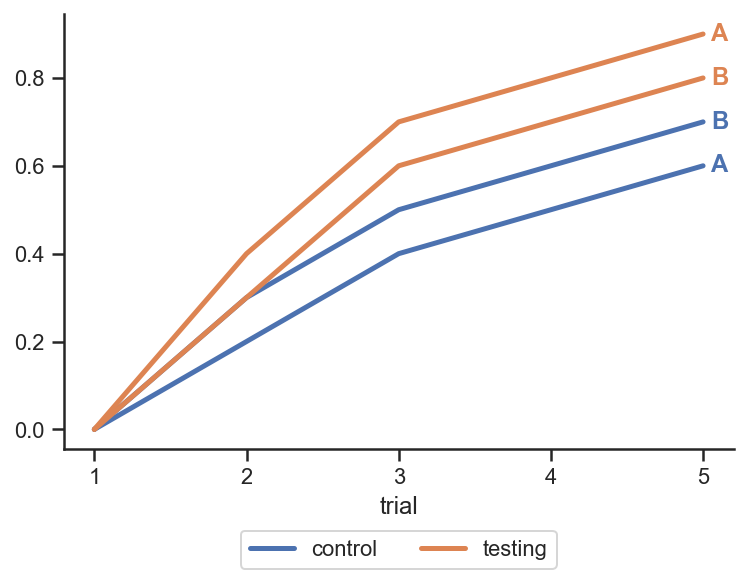

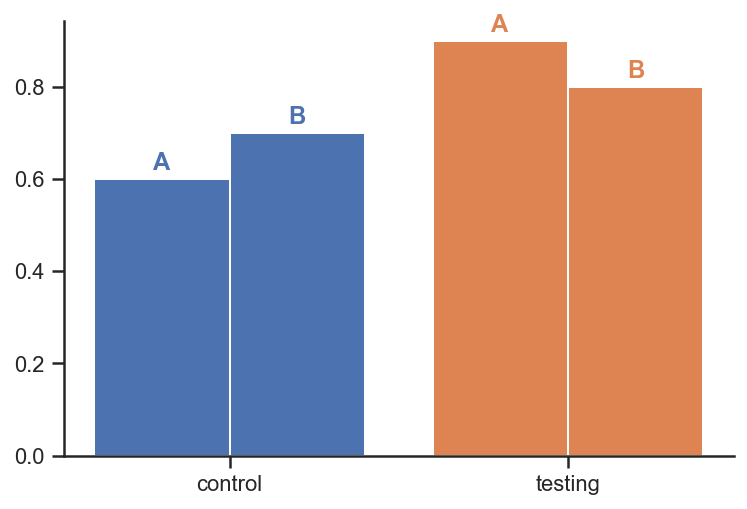

In [512]:
from matplotlib.ticker import MaxNLocator

def line_labels(last, pos='value', sep=1, delta=0.1, max_iters=20):
    labels = last.copy()
    for _ in range(max_iters):
        changed = False
        for i, row_i in labels.iterrows():
            for j, row_j in labels.iterrows():
                if j <= i: continue
                pos_i = row_i[pos]
                pos_j = row_j[pos]
                if abs(pos_i - pos_j) < sep:
                    if pos_i < pos_j:
                        labels.at[i, pos] -= delta
                        labels.at[j, pos] += delta
                    else:
                        labels.at[i, pos] += delta
                        labels.at[j, pos] -= delta
                    changed = True
        if not changed: break
    return labels
    

def plot_lines(df, x='trial', y='value', group='group', split='variable', label=True, xlabel=None, ylabel='', yaxis=None, ax=None, labelfontsize=12):
    if ax is None: fig, ax = plt.subplots()  
    
    g = sns.lineplot(data=df, x=x, y=y, hue=group, units=split, estimator=None, markers=True, ax=ax)
    sns.despine()
    if yaxis is not None: g.set(ylim=(yaxis[0], yaxis[1]), yticks=np.arange(yaxis[0], yaxis[1] + yaxis[2], step=yaxis[2]))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.3))
    if xlabel is not None: ax.set_xlabel(xlabel)
    if ylabel is not None: ax.set_ylabel(ylabel)
    
    def pt_to_data_coord(x, y):
        t = ax.transData.inverted()
        return t.transform((x, y)) - t.transform((0, 0))
    if label is not None:
        palette = sns.color_palette()
        groups = list(df[group].unique())
        last = df[[x, y, group, split]].sort_values([x]).groupby([group, split]).last().reset_index()
        sep = pt_to_data_coord(0, labelfontsize)[1]
        labels = line_labels(last, pos=y, sep=sep, delta=sep / 10)
        for i, row in labels.iterrows():
            color = palette[groups.index(row[group]) % len(palette)]
            ax.annotate(
                row[split],
                (row[x], row[y]),
                xytext=(4, 0),
                textcoords='offset points',
                horizontalalignment='left', verticalalignment='center',
                 color=color, linespacing=1, fontsize=labelfontsize, fontweight='bold')
            
            
def plot_bars(df, x='group', y='value', split='variable', label='variable', xlabel=None, ylabel='', yaxis=None, ax=None, barfrac=0.8, labelfontsize=12):
    if ax is None: fig, ax = plt.subplots()
    xs = df[x].unique()
    splits = df[split].unique() if split in df else [None]
    xvals = pd.Series(np.arange(len(xs)), index=xs)
    width = barfrac / len(splits)
    palette = sns.color_palette()
    colors = pd.Series([palette[x % len(palette)] for x in range(len(xs))], index=xs)
    
    for i, s in enumerate(splits):
        df_split = df[df[split] == s] if split in df else df
        bar = ax.bar(xvals[df_split[x]] + i * width + width / 2, df_split[y], width, color=colors[df_split[x]])
        if label is not None:
            labels = ax.bar_label(bar, labels=df_split[label], padding=2, fontsize=labelfontsize, fontweight='bold', linespacing=1)
            for i, color in enumerate(colors[df_split[x]]): labels[i].set_color(color)
    
    sns.despine()
    ax.set_xticks(xvals + len(splits) * width / 2)
    ax.set_xticklabels(xs)
    if yaxis is not None:
        ax.set_ylim(yaxis[0], yaxis[1])
        ax.set_yticks(np.arange(yaxis[0], yaxis[1] + yaxis[2], step=yaxis[2]))
    if xlabel is not None: ax.set_xlabel(xlabel)
    if ylabel is not None: ax.set_ylabel(ylabel)

df = pd.melt(pd.DataFrame([
    ['control', 1, 0, 0], ['control', 2, 0.2, 0.3], ['control', 3, 0.4, 0.5], ['control', 4, 0.5, 0.6], ['control', 5, 0.6, 0.7],
    ['testing', 1, 0, 0], ['testing', 2, 0.4, 0.3], ['testing', 3, 0.7, 0.6], ['testing', 4, 0.8, 0.7], ['testing', 5, 0.9, 0.8],
], columns=['group', 'trial', 'A', 'B']), id_vars=['group', 'trial'])
plot_lines(df)
plot_bars(df[df['trial'] == 5])


In [543]:
def correlation(df1, df2, value_name='value'):
    merged = df1.merge(df2, on=[x for x in df1.columns if x != value_name])  # Drops rows that only appear in one df.
    values1 = merged['{}_x'.format(value_name)]
    values2 = merged['{}_y'.format(value_name)]
    return values1.corr(values2, method='pearson')

df1 = pd.melt(pd.DataFrame(
    columns=['group', 'trial', 'cr', 'cr2'],
    data=[
        [1, 2, 3, 6],
        [2, 3, 4, 8],
        [3, 4, 5, 10],
    ]
), id_vars=['group', 'trial'])
df2 = pd.melt(pd.DataFrame(
    columns=['group', 'trial', 'cr', 'cr2'],
    data=[
        [1, 2, 3, 7],
        [2, 3, 5, 8],
        [3, 4, 6, 9],
    ]
), id_vars=['group', 'trial'])
correlation(df1, df2)

0.9585966633705806

In [423]:
def trials_to_sessions(df, trials_per_session, trial_name='trial', session_name='session', keep_first=False):
    result = df[df[trial_name] % trials_per_session == 0 | (keep_first and df[trial_name] == 1)]
    result = result.rename(columns={ trial_name: session_name })
    result[session_name] = result[session_name].div(trials_per_session).astype(int)
    return result

df = pd.melt(pd.DataFrame(
    columns=['group', 'trial', 'cr'],
    data=[
        [1, 1, 1],
        [1, 2, 2],
        [1, 3, 3],
        [1, 4, 4],
        [1, 5, 5],
        [1, 6, 6],
        [2, 1, 2],
        [2, 2, 4],
        [2, 3, 6],
        [2, 4, 8],
        [2, 5, 10],
        [2, 6, 12],
    ]
), id_vars=['group', 'trial'])
trials_to_sessions(df, 2)

,group,session,variable,value
1,1,1,cr,2
3,1,2,cr,4
5,1,3,cr,6
7,2,1,cr,4
9,2,2,cr,8
11,2,3,cr,12


# Testing (UX, DX)

In [373]:
class TestExperiment(ClassicalConditioningExperiment):
    def __init__(self, n=10, partial_prob=0.5):
        super().__init__({
            'control': seq(trial('AB+'), repeat=6),
            'special': seq(trial('AB+'), repeat=6),
        })
        self.results = pd.melt(pd.DataFrame(
            columns=['group', 'trial', 'AB'],
            data=[
                ['control', 1, 0.2],
                ['control', 2, 0.3],
                ['control', 3, 0.4],
                ['control', 4, 0.5],
                ['control', 5, 0.6],
                ['control', 6, 0.7],
                ['special', 1, 0.2],
                ['special', 2, 0.3],
                ['special', 3, 0.4],
                ['special', 4, 0.5],
                ['special', 5, 0.6],
                ['special', 6, 0.7],
            ]
        ), id_vars=['group', 'trial'])
        self.meta = dict(ylabel='hi')
        self.plots = [
            lambda df, ax, **info: plot_lines(df, ax=ax),
            lambda df, ax, **info: plot_bars(df[df['trial'] == 6], ax=ax),
        ]

    def summarize(self):
        return pd.melt(self.dataframe(lambda x: {
            'AB': conditioned_response(x['trial'], x['response'], ['A', 'B']),
        }), id_vars=['group', 'trial']).groupby(['group', 'trial', 'variable']).mean().reset_index()

Generalization_AddVsRemove
    NOT IMPLEMENTED
Generalization_NovelVsInhibitor
    correlation: nan


,group,variable,value
0,control,A,9.0
1,external inhibition,AC,5.5
2,conditioned inhibition,AX,2.0


,group,variable,value
0,control,A,1.0
1,external inhibition,AC,1.0
2,conditioned inhibition,AX,1.0


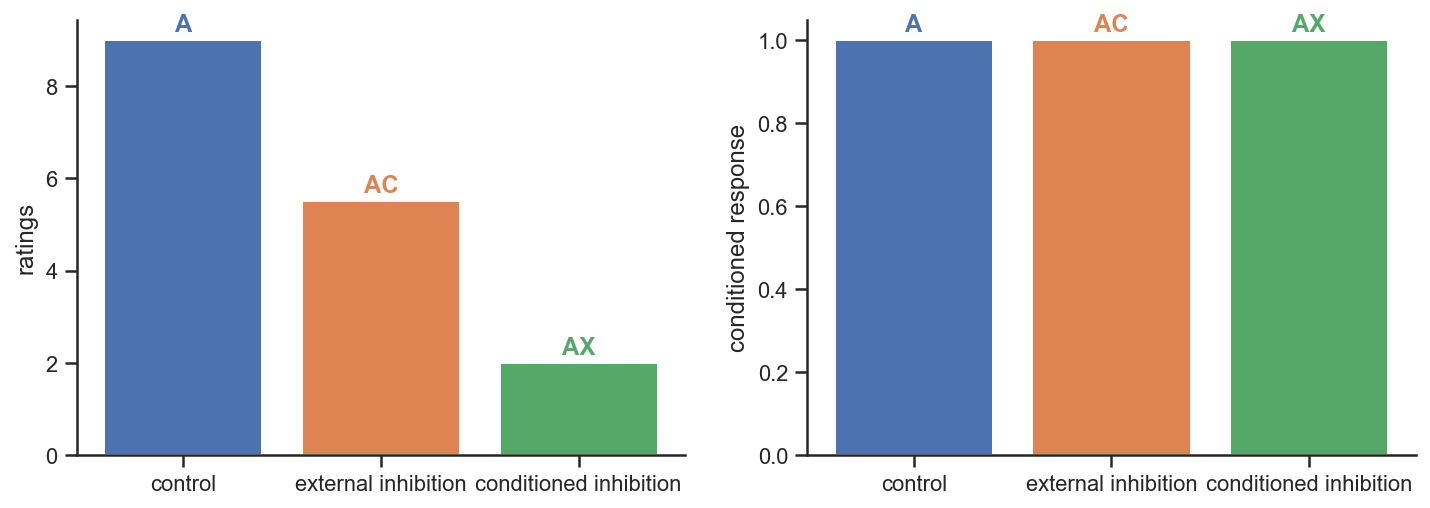

In [555]:
class RandomModel:
    """Produces response with probability that changes linearly with each US."""
    def __init__(self, start=0.2, delta=0.1):
        self.prob = start
        self.start = start
        self.delta = delta
        
    def reset(self):
        self.prob = start
    
    def act(self, cs, ctx, us):
        if us > 0:
            self.prob = max(min(self.prob + self.delta, 1), 0)
            return 1
        if len(cs) > 0:
            return random.choices([1, 0], weights=[self.prob, 1-self.prob])[0]
        return 0

def run_test():
#     exp = TestExperiment()
    for exp in experiments('Gen*'):
        print(exp.name)
        for g, group in exp.stimuli.items():
            for subject in range(1):
                model = RandomModel()
                for i, trial in enumerate(group):
                    for t, timestep in enumerate(trial):
                        cs, ctx, us = timestep
                        res = model.act(cs, ctx, us)
                        exp.data[g][i][t]['response'].append(res)
    
        try:
            results = exp.results
            summary = exp.summarize()
            print('    correlation:', correlation(results, summary))
            display(results)
            display(summary)
            exp.plot(show='both')
        except NotImplementedError:
            print('    NOT IMPLEMENTED')
            continue

run_test()

In [ ]:
# X compute cr per trial
# X compare simulated vs experimental stats

# X plotting

# X cr per trial = [group, trial, cr]; group by session?
# X cr per group = [group, cr]; select by phase? select by trial stimuli?

# QUESTIONS
# session vs trial?
# how to measure CR not UR? Use sum or max over timesteps in trial?
# what is suppression ratio baselines?

# QUESTIONS
# suppression ratio for only aversive stimuli?
# suppression ratio smoothing? edge case of denom 0?

# IDEA: allow for both summary stats input and full experimental data
# IDEA: configurable evaluation function

# QUESTIONS
# aggregating across sessions
# suppression ratio, vs suppression, vs normal cr

# don't implement differences, experiment-level appetitive/aversive, us-level appetitive/aversive, transform all into common framework
# averaging
